In [1]:
import pandas as pd
import numpy as np

np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import sys
import re

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import KFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import xgbfir
%matplotlib inline

train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5') #zbiór testowy bez odpowiedzi

train['price_log'] = np.log(train['price'])
train_test = pd.concat([train, test], sort=False)
train_test.fillna(-1, inplace=True)

In [2]:
def bread_geo_func(row): #concatenate breadcrumbs with geo_block, erase repeated values
    b_str = ','.join(row['breadcrumbs']).lower().strip()
    g_str = ','.join(row['geo_block']).lower().strip()
    b_g_str = (b_str +','+ g_str).replace('ул.', 'ул').replace('пер.', 'пер').replace('пр-кт.', 'пр-кт').\
                replace('проезд.', 'проезд').replace('б-р.', 'б-р')
    
    b_g_list = sorted(list(set(b_g_str.split(',')) - set(['москва', 'г. москва'])))
    return b_g_list

train_test['bread_geo'] = train_test[['breadcrumbs', 'geo_block']].apply(bread_geo_func, axis=1) 


In [3]:
district_list = ['Арбат', 'Басманный', 'Хамовники', 'Красносельский', 'Мещанский', 'Пресненский', 'Таганский', 'Тверской',\
                 'Якиманка', 'Замоскворечье','Аэропорт', 'Беговой', 'Бескудниковский', 'Хорошёвский', 'Ховрино', \
                 'Дмитровский', 'Головинский', 'Коптево', 'Левобережный', 'Молжаниновский', 'Савёловский', 'Сокол',\
                 'Тимирязевский', 'Восточное Дегунино', 'Войковский', 'Западное Дегунино','Алексеевский', 'Алтуфьевский',\
                 'Бабушкинский', 'Бибирево', 'Бутырский', 'Ярославский', 'Южное Медведково', 'Лианозово',\
                 'Лосиноостровский', 'Марфино', 'Марьина Роща', 'Останкинский', 'Отрадное', 'Ростокино',\
                 'Северное Медведково', 'Северный', 'Свиблово', 'Богородское', 'Гольяново', 'Ивановское', 'Измайлово',\
                 'Косино-Ухтомский', 'Метрогородок', 'Новогиреево', 'Новокосино', 'Перово', 'Преображенское',\
                 'Северное Измайлово', 'Соколиная Гора', 'Сокольники', 'Вешняки', 'Восточное Измайлово', 'Восточный',\
                 'Южнопортовый', 'Капотня', 'Кузьминки', 'Люблино', 'Лефортово', 'Марьино', 'Некрасовка', 'Нижегородский',\
                 'Печатники', 'Рязанский', 'Текстильщики', 'Выхино-Жулебино', 'Бирюлёво Восточное', 'Бирюлёво Западное',\
                 'Братеево', 'Царицыно', 'Чертаново Центральное', 'Чертаново Южное', 'Чертаново Северное', 'Даниловский',\
                 'Донской', 'Москворечье-Сабурово', 'Нагатино-Садовники', 'Нагатинский Затон', 'Нагорный',\
                 'Орехово-Борисово Южное', 'Орехово-Борисово Северное', 'Зябликово', 'Академический', 'Черёмушки',\
                 'Гагаринский', 'Ясенево', 'Южное Бутово', 'Коньково', 'Котловка', 'Ломоносовский', 'Обручевский',\
                 'Северное Бутово', 'Тёплый Стан', 'Зюзино', 'Дорогомилово', 'Фили-Давыдково', 'Филёвский Парк',\
                 'Крылатское', 'Кунцево', 'Можайский', 'Ново-Переделкино', 'Очаково-Матвеевское', 'Проспект Вернандского',\
                 'Раменки', 'Солнцево', 'Тропарёво-Никулино', 'Внуково', 'Хорошёво-Мнёвники', 'Южное Тушино', 'Куркино',\
                 'Митино', 'Покровское-Стрешнево', 'Северное Тушино', 'Строгино', 'Щукино', 'Крюково', 'Матушкино',\
                 'Савёлки', 'Силино', 'Старое Крюково', 'Щербинка', 'Московский', 'Кокошкино', 'Внуково', 'Старосырово',\
                 'Шарапово', 'Марушкино', 'Постниково', 'Знамя Октября', 'сосенское', 'внуковское', 'рязановское',\
                 'филимонковское', 'марушкинское', 'воскресенское']
district_list = [district.lower() for district in district_list]

In [4]:
def metro_new2_func(row):
    metro_ = sorted([i for i in row['bread_geo'] if ('мцк ' in i or 'м. ' in i)])
    if len(metro_)>0 :
        return ', '.join(metro_)
    return 'missing'
train_test['metro_new2'] = train_test[['bread_geo']].apply(metro_new2_func, axis=1)

def metro_func(row):
    metro_ = sorted([i for i in row['bread_geo'] if ('мцк ' in i)])
    if len(metro_)>0 :
        return ', '.join(metro_)
    return 'missing'
train_test['metro'] = train_test[['bread_geo']].apply(metro_func, axis=1)
def station_func(row):
    station_ = sorted([i for i in row['bread_geo'] if ('м. ' in i)])
    if len(station_)>0 :
        return ', '.join(station_)
    return 'missing'
train_test['station'] = train_test[['bread_geo']].apply(station_func, axis=1)


def street_func(row):
    ext = ['ул ', 'б-р', 'пер ', 'пр-кт', 'аллея', 'проезд', 'ш ', 'пл ', 'наб ']
    street_ = sorted([i for i in row['bread_geo'] if any(ext_ in i for ext_ in ext)])
    if len(street_)>0 :
        return ', '.join(street_)
    return 'missing'
train_test['street'] = train_test[['bread_geo']].apply(street_func, axis=1)

def district2_func(row):
    district_ = [name for name in district_list if (name in ','.join(row['bread_geo']))]
    if len(district_) > 0:
        return ', '.join(district_)
    district_ = [i for i in row['bread_geo'] if ('п.' in i or 'с.' in i)]
    if len(district_)>0:
        return ', '.join(district_)
    return 'missing'
train_test['district_2'] = train_test[['bread_geo']].apply(district2_func, axis=1)

train_test['NowaMoskwa'] = train_test['bread_geo'].map(lambda x: 1 if 'новая москва' in x else 0)

counts = train_test['metro_new2'].value_counts()
mask = train_test['metro_new2'].isin(counts[counts < 5].index)
train_test.loc[mask, 'metro_new2'] = 'Other'

counts = train_test['station'].value_counts()
mask = train_test['station'].isin(counts[counts < 4].index)
train_test.loc[mask, 'station'] = 'Other'

counts = train_test['street'].value_counts()
mask = train_test['street'].isin(counts[counts < 4].index)
train_test.loc[mask, 'street'] = 'Other'

counts = train_test['district_2'].value_counts()
mask = train_test['district_2'].isin(counts[counts < 4].index)
train_test.loc[mask, 'district_2'] = 'Other'

In [6]:
from datetime import datetime

months = {'января' : 'january',
         'февраля' : 'february', 
         'марта' : 'march',
         'апреля' : 'april',
         'мая' : 'may',
         'июня' : 'june',
         'июля' : 'july',
         'августа' : 'august',
         'сентября' : 'september',
         'октября' : 'october',
         'ноября' : 'november',
         'декабря' : 'december'}  

train_test['date_date'] = train_test['date'].map(lambda x: str(x[0].strip()) if (type(x) == list) & (len(x)>=1) else '21 мая 2019')

def date_day(row):
    if row.startswith('вчера'):
        d = '20 мая 2019'
    elif row.startswith('сегодня'):
        d = '21 мая 2019'
    else:
        if len(row.split()) == 2: 
            d = row + ' 2019'
        else:
            d = row
    d = ' '.join([months.get(i, i) for i in d.split()])
    d = datetime.strptime(d , '%d %B %Y')   
    return d    

today = datetime(2019, 5, 21)
def count_mean(row):
    
    return round(row['count_visit'] / ((today - row['date_day']).days +1), 2)

train_test['date_day'] = train_test['date_date'].map(date_day)
train_test['date_days'] = train_test['date_day'].map(lambda x: (today - x).days)
train_test['date_month_y'] = train_test['date_day'].dt.strftime('%Y-%b')
train_test['date_year'] = train_test['date_day'].dt.year
train_test['date_actual'] = train_test['date'].map(lambda x: 1 if (type(x) == list) & (len(x)==4) else 0)
train_test['count_visit'] = train_test['date'].map(lambda x: int(x[1].strip()) if (type(x) == list) & (len(x)>=2) else 0)
train_test['count_visit'] = train_test[['count_visit', 'date_day']].apply(count_mean, axis=1)

counts = train_test['date_month_y'].value_counts()
mask = train_test['date_month_y'].isin(counts[counts < 7].index)
train_test.loc[mask, 'date_month_y'] = 'Other'

In [7]:
train_test['cv_log'] = np.log(train_test['count_visit']*100)
def cv_g(row):
    if row['cv_log'] > 4.7:
        return 4
    elif row['cv_log'] >= 3.6:
        return 3
    elif row['cv_log'] >= 2.4:
        return 2
    elif row['cv_log'] > 1.9:
        return 1
    return 0
train_test['cv_log_g'] = train_test[['cv_log']].apply(cv_g, axis=1)

In [8]:
def security_(x):
    if x == -1:
        return -1
    elif x in ('No', 'no', 'not allowed'):
        return 0
    elif x in ('closed area', 'fenced area', 'enclosed courtyard'):
        return 2
    elif x in ('video surveillance', 'Video surveillance'):
        return 3
    elif x == 'Concierge':
        return 4
    return 1
train_test['security_cat'] = train_test['Security:'].map(security_).astype('int8')

train_test['Ad type:'] = train_test['Ad type:'].map(lambda x: 'secondary' if x == -1 else x)

def construction_secondary(row):
    if ((row['Construction phase:'] == -1) & (row['Ad type:'] == 'secondary')):
        return 'Finish'
    return row['Construction phase:']
train_test['Construction phase:'] = train_test[['Construction phase:', 'Ad type:']].apply(construction_secondary, axis=1) 



In [9]:
train_test['metro_new2_cat'] = pd.factorize(train_test['metro_new2'])[0]
train_test['metro_cat'] = pd.factorize(train_test['metro'])[0]
train_test['station_cat'] = pd.factorize(train_test['station'])[0]
train_test['district_2_cat'] = pd.factorize(train_test['district_2'])[0]
train_test['street_cat'] = pd.factorize(train_test['street'])[0]

train_test['date_cat'] = pd.factorize(train_test['date_month_y'])[0]

train_test['building_type_cat'] = pd.factorize(train_test['Building type:'])[0]
train_test['object_type_cat'] = pd.factorize(train_test['Object type:'])[0]
train_test['ad_type_cat'] = pd.factorize(train_test['Ad type:'])[0]
train_test['contruction_phase_cat'] = pd.factorize(train_test['Construction phase:'])[0]
train_test['housing_class_cat'] = pd.factorize(train_test['Housing class:'])[0]
train_test['elevator_cat'] = (train_test['Elevator:'] == 'yes').astype('int8')
train_test['bathroom_type_cat'] = pd.factorize(train_test['Bathroom type:'])[0]
train_test['balcony_type_cat'] = pd.factorize(train_test['Balcony type:'])[0]
#train_test['mortgage_cat'] = (train_test['Mortgage possible:'] == 'yes').astype('int8')
train_test['view_cat'] = pd.factorize(train_test['The view from the window:'])[0]
#train_test['garbage_chute_cat'] = (train_test['Garbage chute:'] == 'yes').astype('int8')
train_test['repair_cat'] = pd.factorize(train_test['Repair:'])[0]
#train_test['fridge_cat'] = (train_test['Fridge:'] == 'yes').astype('int8')
#train_test['phone_cat'] = (train_test['Phone:'] == 'yes').astype('int8')
#train_test['furniture_cat'] = (train_test['Furniture:'] == 'yes').astype('int8')
train_test['free_layout_cat'] = (train_test['Free layout:'] == 'yes').astype('int8')
#train_test['bargain_cat'] = (train_test['It is possible to bargain:'] == 'yes').astype('int8')
train_test['floor_covering_cat'] = pd.factorize(train_test['Floor covering:'])[0]
train_test['room_type_cat'] = pd.factorize(train_test['Room type:'])[0]
#train_test['internet_cat'] = (train_test['Internet:'] == 'yes').astype('int8')
#train_test['kitchen_furniture_cat'] = (train_test['Kitchen furniture:'] == 'yes').astype('int8')
#train_test['tv_cat'] = (train_test['TV:'] == 'yes').astype('int8')
#train_test['washing_machine_cat'] = (train_test['Washing machine:'] == 'yes').astype('int8')
train_test['foundation_type_cat'] = pd.factorize(train_test['Foundation type:'])[0]
#train_test['overlap_type_cat'] = pd.factorize(train_test['Overlap type:'])[0]
#train_test['type_of_building_cat'] = pd.factorize(train_test['Type of the building:'])[0]
#train_test['playground_cat'] = (train_test['Playground:'] == 'yes').astype('int8')
train_test['class_cat'] = pd.factorize(train_test['Class:'])[0]


In [10]:
train_test['media_cat'] = ((train_test['Internet:']=='yes') | \
                               (train_test['Phone:']=='yes') | (train_test['TV:']=='yes')).astype('int8')
train_test['is_furniture_cat'] = ((train_test['Fridge:']=='yes') | (train_test['Kitchen furniture:']=='yes') |\
                               (train_test['Washing machine:']=='yes') | (train_test['Furniture:']=='yes')).astype('int8')

In [11]:


# train_test['Hclass_building'] = train_test[['Housing class:', 'Building type:']]\
#             .apply(lambda row: str(row['Housing class:']) + str(row['Building type:']), axis=1)
# train_test['Hclass_building_cat'] = pd.factorize(train_test['Hclass_building'])[0]

train_test['constr_hc_metro'] = train_test[['Construction phase:', 'Housing class:', 'metro']]\
            .apply(lambda row: str(row['Construction phase:']) + str(row['Housing class:']) + str(row['metro']), axis=1)
train_test['constr_hc_metro_cat'] = pd.factorize(train_test['constr_hc_metro'])[0]

train_test['ad_hc_metro'] = train_test[['Ad type:', 'Housing class:', 'metro']]\
            .apply(lambda row: str(row['Ad type:']) + str(row['Housing class:']) + str(row['metro']), axis=1)
train_test['ad_hc_metro_cat'] = pd.factorize(train_test['ad_hc_metro'])[0]

train_test['hc_station'] = train_test[['Housing class:', 'station']]\
            .apply(lambda row: str(row['Housing class:']) + str(row['station']), axis=1)
train_test['hc_station_cat'] = pd.factorize(train_test['hc_station'])[0]

# train_test['nm_hc'] = train_test[['NowaMoskwa', 'Housing class:']]\
#             .apply(lambda row: str(row['NowaMoskwa']) + str(row['Housing class:']), axis=1)
# train_test['nm_hc_cat'] = pd.factorize(train_test['nm_hc'])[0]

def hc_cp_m_vhp(row):
    if row['Housing class:'] == 'Elite class':
        if row['Construction phase:'] == 'Commissioned':
            if row['metro'] in ['мцк лужники', 'мцк деловой центр']:
                return 1
            return 0
        elif row['Construction phase:'] == 'Playground':
            if row['metro'] in ['мцк деловой центр']:
                return 1
            return 0
        elif row['Construction phase:'] == 'Finish':
            if row['metro'] in ['мцк дубровка', 'мцк площадь гагарина', 'мцк лужники']:
                return 1
            return 0
        return 0
    elif row['Housing class:'] == 'Comfort class' and row['Construction phase:'] == 'Project' and row['metro'] in ['мцк кутузовская']:
        return 1
    elif row['Housing class:'] == 'Business class' and row['Construction phase:'] == 'Commissioned' and row['metro'] in ['мцк локомотив']:
        return 1
    elif row['Housing class:'] == -1 and row['Construction phase:'] == -1 and row['metro'] in ['мцк дубровка', 'мцк лужники']:
        return 1
    return 0
train_test['hc_cp_m_vhp'] = train_test[['Housing class:', 'Construction phase:', 'metro']].apply(hc_cp_m_vhp, axis=1)

In [21]:
def get_feats(df):
    black_list=['price', 'price_log', 'id']
    wo = ['cv_log',  'nm_hc_cat', 'hc_ad_m_vhp', 'date_year', 'date_cat']
    black_list = black_list + wo
    feats = df.select_dtypes(include=['number']).columns 
    #feats = feats[ (feats != 'price') & (feats != 'price_log') & (feats != 'id')].values
    return [x for x in feats if x not in black_list]

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def fair_obj(dtrain, preds):
    labels = dtrain
    x = preds - labels
    c = 1
    den = abs(x) + c
    grad = c*x/c
    hess = c*c/den*den
    return grad, hess

def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
#     y_true = np.exp(y_log_true) 
#     y_pred = np.exp(y_log_pred) 
    return 'mae', mean_absolute_error(y_log_true, y_log_pred)

def get_models():
    return [
        #('dummy_median', DummyRegressor(strategy='median')),
        #('dt_md5', DecisionTreeRegressor(max_depth=5)),
        #('RF_md5', RandomForestRegressor(max_depth=5, max_features=0.8)),
        ('XGB md-8, n-110, lr-0.2, s-1, cs-1', XGBRegressor(max_depth=8, n_estimators=110, learning_rate=0.2,\
                                                    subsample=1,colsample_bytree=1, random_state=0))#, objective=fair_obj)),
        #('CB_md5', CatBoostRegressor(depth=5, verbose=False))
    ]

def run_cv(model, X, y, folds=4, target_log=False, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds, random_state=0, shuffle=True)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_train = np.log(y_train)
              
        model.fit(X_train, y_train)
#         model.fit(X_train, y_train, eval_metric=mae_log_eval, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)
        
        y_pred = np.exp(y_pred)
        y_pred[y_pred < 0] = y_train.min() 
            
        score = success_metric(y_test, y_pred)
        scores.append( score )

    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), success_metric=mean_absolute_error):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        y = np.exp(y)
        y_pred = np.exp(y_pred)
        y_pred[ y_pred<0 ] = y.min()
        
        return success_metric(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(df, plot_lc=False, folds=3, ylim=(0, 15)):
    X, y  = get_X(df), get_y(df)

    for model_name, model_ in get_models():
        score_mean, score_std = run_cv(model_, X, y, folds=folds)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        
        if model_name.startswith('XGB'):
            model = model_
            model.fit(X, y)
            xgbfir.saveXgbFI(model, feature_names=get_feats(df), OutputXlsxFile='../output/bost_fi.xlsx')
            
        if False == plot_lc: continue
        plt = plot_learning_curve(model_, model_name, X, y, ylim=ylim, cv=folds)
        plt.show()
        
        model = model_
        model.fit(X, y)
        feats = get_feats(df)
        title='Feature Importance. {0}'.format(model_)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    
        
        
def submit(df_train, df_test, model, file='model.csv'):
    X_train = get_X(df_train)
    X_test = get_X(df_test)
    
    y = get_y(df_train)
    y = np.log(y)
        
    model = model
    model.fit(X_train, y)#, eval_metric=mae_log_eval)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)
    y_pred[y_pred<0] = y.min()
    
    df_test['price'] = y_pred
    df_test[ ['id', 'price'] ].to_csv('../output/{}'.format(file), index=False) 

In [22]:
train = train_test[train_test['price'] != -1]
train = train.drop(['id'], axis=1)
train = train[train['count_visit']<20]
test = train_test[train_test['price'] == -1]
test = test.drop(['price'], axis=1)
test['id'] = test['id'].astype('int64')
print(get_feats(train))
run(train, plot_lc=False, folds=4)

['NowaMoskwa', 'date_days', 'date_actual', 'count_visit', 'cv_log_g', 'security_cat', 'metro_new2_cat', 'metro_cat', 'station_cat', 'district_2_cat', 'street_cat', 'building_type_cat', 'object_type_cat', 'ad_type_cat', 'contruction_phase_cat', 'housing_class_cat', 'elevator_cat', 'bathroom_type_cat', 'balcony_type_cat', 'view_cat', 'repair_cat', 'free_layout_cat', 'floor_covering_cat', 'room_type_cat', 'foundation_type_cat', 'class_cat', 'media_cat', 'is_furniture_cat', 'constr_hc_metro_cat', 'ad_hc_metro_cat', 'hc_station_cat', 'hc_cp_m_vhp']
[XGB md-8, n-110, lr-0.2, s-1, cs-1]: 5.102396493040397 +/-0.0624942899123992


In [23]:
submit(train, test, XGBRegressor(max_depth=8, n_estimators=110, learning_rate=0.2, objective=fair_obj),\
       file='model_xgb_aft.csv')

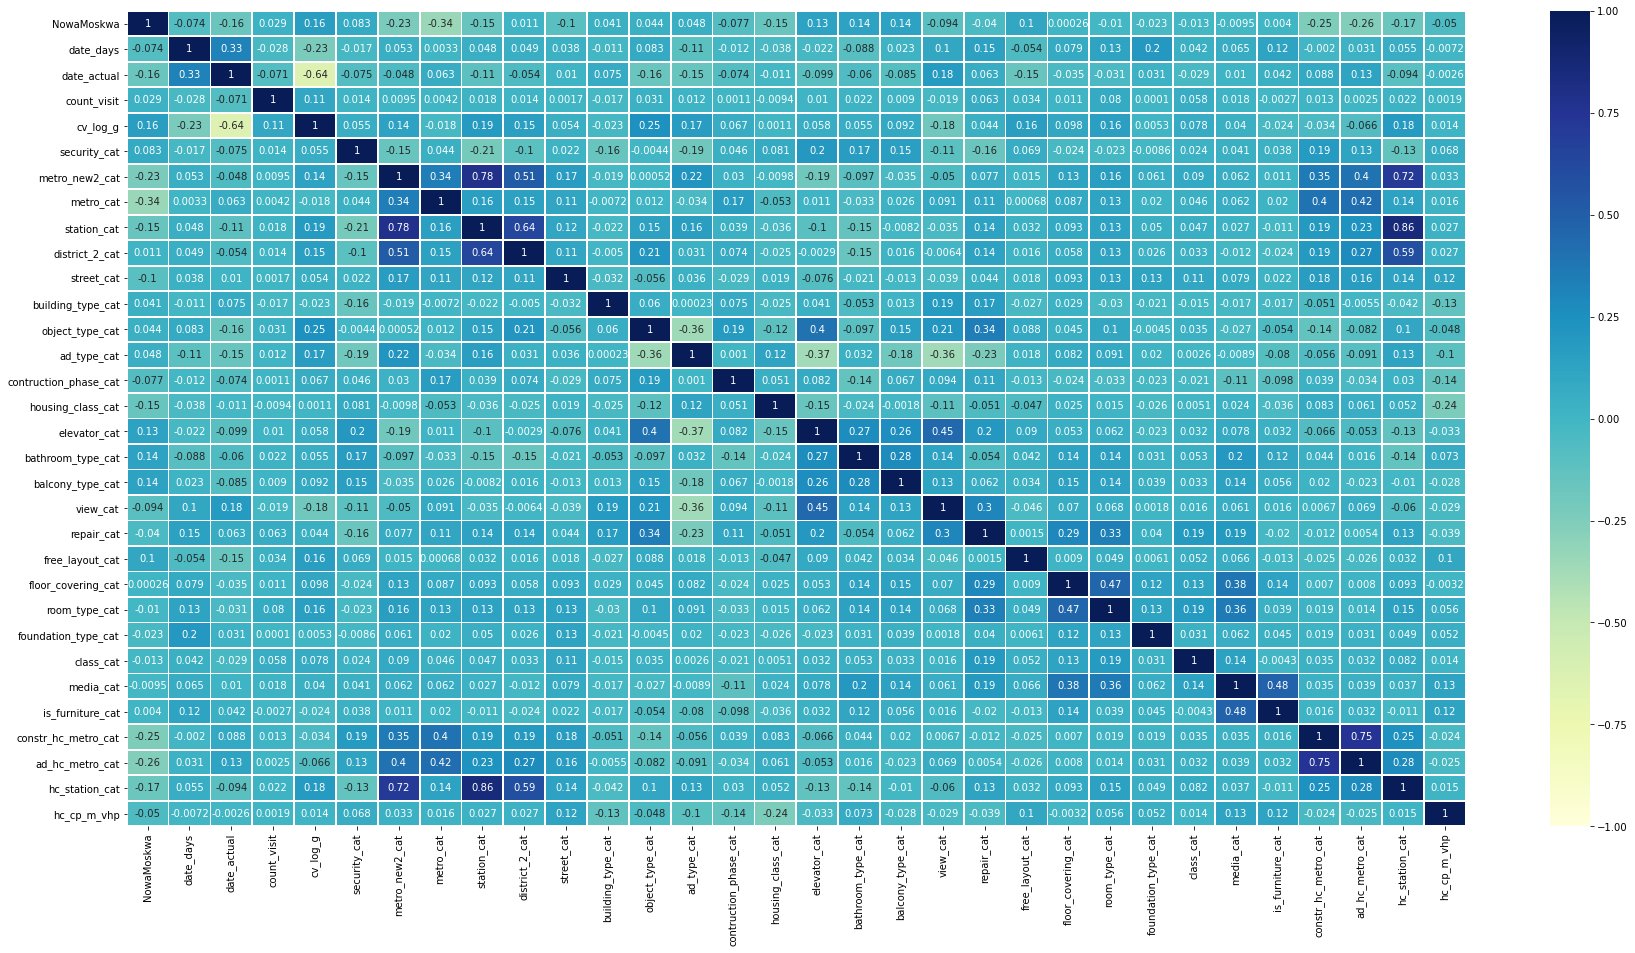

In [17]:
plt.rcParams['figure.figsize']=(30,15)
sns.heatmap(train[get_feats(train)].corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [50]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',131)
def q1(x):
    return x.quantile(0.025)

def q2(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def q4(x):
    return x.quantile(0.97)

col = ['metro']
train.groupby(col)[['price_log']].\
agg([np.mean, np.median, np.min, np.max, 'count']).reset_index().sort_values(('price_log', 'median'), ascending=False)

metro price_log                                    
                                   mean    median      amin      amax count
9           мцк деловой центр  4.134998  3.994155  0.231112  7.347100   758
10               мцк дубровка  3.682172  3.908015  1.460167  6.358120   275
24       мцк площадь гагарина  3.576912  3.605738  2.079442  5.971899   522
30               мцк шелепиха  2.900380  2.842925  1.308333  6.276343  3279
25              мцк ростокино  2.698024  2.750384  0.932164  5.056182  1146
26         мцк соколиная гора  2.759949  2.724019  1.621341  4.639322   596
1           мцк автозаводская  2.758066  2.723807  1.131402  4.248495   136
12                  мцк зорге  2.682405  2.719030  0.314811  4.382027  1269
13              мцк измайлово  2.682311  2.683024  1.047319  4.369448    62
2              мцк андроновка  2.667289  2.667822  1.686399  3.839452   690
29               мцк хорошёво  2.635118  2.660260  1.488400  4.442651  2129
23           мцк панфиловская  2.681017  2.607329  1.658091  4.517431   477
16            мцк кутузовская  2.721494  2.570415  0.604316  6.866068  3852
5        мцк ботанический сад  2.558823  2.525949  0.815365  4.418841  1507
22               мцк окружная  2.482394  2.388763  1.076630  4.128364   509
8               мцк владыкино  2.383935  2.380718  0.765468  4.204693  1568
11                    мцк зил  2.299034  2.335672  0.553885  3.761200  1954
14                мцк коптево  2.294517  2.322388  0.832909  3.427515  2327
19                мцк лужники  2.701731  2.311545  0.009950  8.006368  3155
7           мцк верхние котлы  2.270097  2.236443  0.875469  3.764773   468
21         мцк новохохловская  2.085846  2.159606  0.828552  3.113515   606
17               мцк лихоборы  2.148856  2.156122  0.896088  4.822618  1488
20          мцк нижегородская  2.154557  2.151332  0.688135  3.173368  1731
18              мцк локомотив  2.173338  2.128572  0.788003  5.105945   734
27              мцк стрешнево  2.361982  2.092314  0.936093  5.605177   584
0                     missing  2.230368  2.079442 -0.198429  5.886104  1226
3              мцк балтийская  2.116925  2.076413  0.405465  5.541264  1362
28              мцк угрешская  2.138002  2.011057  0.974560  6.214608  1643
6   мцк бульвар рокоссовского  2.064991  2.006871  1.225157  3.401197   279
15               мцк крымская  2.018509  1.983756  0.662688  4.248495  7469
31      мцк шоссе энтузиастов  1.941674  1.982142  0.896088  4.363099  1803
4            мцк белокаменная  2.065961  1.895186  1.120178  3.322584    90

In [81]:
col = ['Bathroom type:', 'metro']
df=train.groupby(col)[['price_log']].\
agg([np.mean, np.median, np.min, np.max, 'count']).reset_index().sort_values(('price_log', 'median'), ascending=False)
df

Bathroom type:                      metro price_log                      \
                                                   mean    median      amin   
105            two          мцк деловой центр  4.287773  4.471867  2.491551   
106            two               мцк дубровка  4.159882  4.233287  2.821379   
118            two       мцк площадь гагарина  3.852932  4.041295  2.646175   
9               -1          мцк деловой центр  4.124961  4.008967  0.231112   
124            two               мцк шелепиха  4.077361  3.988984  3.113071   
74        separate               мцк дубровка  3.748189  3.980989  2.260721   
88        separate       мцк площадь гагарина  3.733837  3.926320  2.646175   
73        separate          мцк деловой центр  4.175670  3.926040  3.153590   
56        combined       мцк площадь гагарина  3.927216  3.902175  2.517696   
10              -1               мцк дубровка  3.652300  3.832980  1.460167   
117            two           мцк панфиловская  3.560897  3.569533  3.192121   
101            two       мцк ботанический сад  3.424469  3.531060  2.388763   
24              -1       мцк площадь гагарина  3.472601  3.462606  2.079442   
41        combined          мцк деловой центр  3.773376  3.433665  2.699346   
111            two            мцк кутузовская  3.361039  3.348208  1.302913   
68        separate           мцк белокаменная  3.320832  3.321335  3.318578   
96             two                    missing  3.204866  3.312524 -0.198429   
121            two              мцк стрешнево  3.350146  3.302102  2.302585   
100            two           мцк белокаменная  3.276110  3.276110  3.276110   
116            two               мцк окружная  3.339296  3.232384  2.490723   
98             two             мцк андроновка  3.263965  3.221818  2.995732   
120            two         мцк соколиная гора  3.382331  3.217883  2.756840   
90        separate         мцк соколиная гора  3.041319  3.145443  1.888584   
91        separate              мцк стрешнево  3.150808  3.109932  2.140066   
123            two               мцк хорошёво  3.104794  3.064092  2.476538   
122            two              мцк угрешская  3.063004  3.063004  3.045474   
108            two                  мцк зорге  3.022108  3.040177  2.491551   
94        separate               мцк шелепиха  3.013882  2.996922  2.119863   
33        combined          мцк автозаводская  2.867331  2.995420  2.476538   
97             two          мцк автозаводская  2.894459  2.970414  2.000993   
87        separate           мцк панфиловская  2.947760  2.959965  2.317474   
69        separate       мцк ботанический сад  2.743542  2.945912  1.673351   
66        separate             мцк андроновка  2.956865  2.891598  2.219203   
77        separate              мцк измайлово  2.890372  2.890372  2.890372   
119            two              мцк ростокино  2.941260  2.853949  2.468947   
93        separate               мцк хорошёво  2.838105  2.845152  1.800058   
30              -1               мцк шелепиха  2.820991  2.794638  1.308333   
76        separate                  мцк зорге  2.874079  2.794164  2.091864   
80        separate            мцк кутузовская  2.833337  2.758705  1.193922   
62        combined               мцк шелепиха  2.875126  2.747271  1.673351   
89        separate              мцк ростокино  2.796035  2.743390  1.648659   
114            two          мцк нижегородская  2.772347  2.742896  2.468100   
61        combined               мцк хорошёво  2.696622  2.727199  1.781709   
99             two             мцк балтийская  2.684561  2.726545  2.014903   
65        separate          мцк автозаводская  2.771456  2.714695  2.104134   
36        combined           мцк белокаменная  2.701361  2.701361  2.701361   
1               -1          мцк автозаводская  2.723171  2.696084  1.131402   
13              -1              мцк измайлово  2.685296  2.683024  1.047319   
109            two                мцк коптево  2.62999

In [83]:
df[df[('price_log', 'median')]>4.0]

Bathroom type:                 metro price_log                      \
                                              mean    median      amin   
105            two     мцк деловой центр  4.287773  4.471867  2.491551   
106            two          мцк дубровка  4.159882  4.233287  2.821379   
118            two  мцк площадь гагарина  3.852932  4.041295  2.646175   
9               -1     мцк деловой центр  4.124961  4.008967  0.231112   

                     
         amax count  
105  6.225192   127  
106  5.480639    26  
118  5.454381    81  
9    7.347100   500

In [84]:
def bath_metro_vhp(row):
    if row['Bathroom type:'] == 'two' and row['metro'] in ['мцк деловой центр', 'мцк дубровка', 'мцк площадь гагарина']:
        return 1
    elif row['Bathroom type:'] == -1 and row['metro'] == 'мцк площадь гагарина':
        return 1
    return 0
train_test['bath_metro_vhp'] = train_test[['Bathroom type:','metro']].apply(bath_metro_vhp, axis=1)

In [75]:
def ad_metro_street_vhp(row):
    if row['Ad type:'] == 'from the developer':
        if row['metro'] in ['мцк деловой центр']:
            if row['street'] in ['пер хлебный', 'ул арбат']:
                return 1
            return 0
        elif row['metro'] in ['мцк лужники'] and row['street'] in ['пер всеволожский']:
            return 1
        return 0
    elif row['Ad type:'] == 'new building':
        if row['metro'] in ['мцк лужники'] and row['street'] in ['пер коробейников', 'пер курсовой', 'пер хилков', 'ул фрунзенская 2-я',\
                                                                'пер еропкинский', 'наб пречистенская', 'Other']:
            return 1
        elif row['metro'] in ['мцк деловой центр'] and row['street'] in ['пер богословский', 'Other', 'ул арбат', 'пер звонарский',\
                                                                        'ул новый арбат']:
            return 1
        elif row['metro'] in ['missing'] and row['street'] in ['пер богословский', 'ул новослободская']:
            return 1
        elif row['metro'] in ['мцк дубровка'] and row['street'] in ['пер тессинский', 'пер кривоколенный']:
            return 1
        elif row['metro'] in ['мцк шелепиха'] and row['street'] in ['ул фадеева']:
            return 1
        elif row['metro'] in ['мцк кутузовская'] and row['street'] in ['ул староволынская', 'ул нежинская']:
            return 1
        return 0
    return 0
train_test['ad_metro_street_vhp'] = train_test[['Ad type:','metro', 'street']].apply(ad_metro_street_vhp, axis=1)

In [69]:
def hc_station_vhp(row):
    if row['Housing class:'] == 'Elite class':
        if row['station'] in ['м. тверская', 'м. китай-город', 'м. парк культуры', 'м. смоленская', 'м. чистые пруды', \
                             'м. арбатская', 'Other', 'м. фрунзенская', 'м. новослободская', 'м. полянка', 'м. студенческая',\
                             'м. спортивная', 'м. маяковская', 'м. киевская']:
            return 1
        return 0
    elif row['Housing class:'] == -1 and row['station'] in ['м. новослободская']:
        return 1
    elif row['Housing class:'] == 'Business class' and row['station'] in ['м. первомайская']:
        return 1
    return 0
train_test['hc_station_vhp'] = train_test[['Housing class:','station']].apply(hc_station_vhp, axis=1)

In [28]:
col = ['street']
a = train.groupby(col)[['price_log']].\
agg([np.mean, np.median, np.min, np.max, 'count']).reset_index().sort_values(('price_log', 'median'), ascending=False)

In [27]:
col = ['district_2']
train.groupby(col)[['price_log']].\
agg([np.mean, np.median, np.min, np.max, 'count']).reset_index().sort_values(('price_log', 'median'), ascending=False)

district_2 price_log                      \
                                             mean    median      amin   
136                           хамовники  4.379431  4.571282  2.191654   
5                                 арбат  4.439906  4.502580  1.960095   
66     мещанский, сокол, соколиная гора  3.545617  4.033586  2.525729   
30                        замоскворечье  3.831401  4.007333  2.251292   
36                            кокошкино  3.806132  3.892011  1.526056   
..                                  ...       ...       ...       ...   
149         южное бутово, воскресенское  1.479069  1.439430  1.166572   
59                         марушкинское  1.456401  1.403631  0.604316   
91                   п. новофедоровское  1.381785  1.360977  1.193922   
130  тропарёво-никулино, филимонковское  1.395996  1.323111  0.888395   
134                      филимонковское  1.395052  1.311032  0.883768   

                     
         amax count  
136  6.419065   207  
5    6.670741   134  
66   4.077537     3  
30   5.539961    79  
36   6.295672    10  
..        ...   ...  
149  1.994700    14  
59   2.251292   118  
91   1.515127    13  
130  2.569186   171  
134  2.468100   105  

[157 rows x 6 columns]

In [29]:
# df = train.groupby(col)[['price_log']].\
# agg([np.mean, np.median, np.min, np.max, 'count']).reset_index().sort_values(('price_log', 'median'), ascending=False)
a[a[('price_log', 'median')]>4.0]

street price_log                                    
                             mean    median      amin      amax count
32          пер хлебный  5.612871  6.029771  4.166665  6.425614     7
21     пер коробейников  4.728543  5.692138  0.009950  6.736279    28
23         пер курсовой  5.699222  5.611338  5.316403  6.255443     9
13     пер богословский  5.460591  5.570480  0.231112  6.819798    31
31           пер хилков  5.411048  5.554393  4.378771  6.693832    41
197  ул фрунзенская 2-я  5.670748  5.273170  4.941642  6.693832     6
19      пер еропкинский  5.363629  5.269918  4.989956  5.749393    15
15     пер всеволожский  5.199952  5.148831  4.901192  5.448976     5
29       пер тессинский  5.033431  5.050119  4.354398  6.358120    16
11    наб пречистенская  5.125391  4.959763  4.859812  5.556596     3
22    пер кривоколенный  4.880699  4.918807  4.561218  5.123964     4
195          ул фадеева  4.816510  4.881437  3.688879  5.747608    37
66             ул арбат  4.925356  4.799338  3.795481  5.885568    31
20       пер звонарский  4.774520  4.741137  4.605170  5.010635     4
148      ул новый арбат  4.588053  4.560140  2.939162  6.670741    67
180   ул староволынская  4.781512  4.553877  3.637586  6.153073     3
146   ул новослободская  4.421729  4.500343  4.227096  4.537748     3
143        ул нежинская  4.499588  4.430206  2.140066  5.962061    40
26     пер подсосенский  4.105266  4.321047  2.541602  4.464067    11
98          ул ефремова  4.273558  4.179064  2.694627  6.135565   102
34    пер электрический  4.134284  4.137244  3.404857  4.726414     9
138           ул мытная  4.047556  4.062647  4.017374  4.062647     3

In [66]:
def vhp_build_nhc_con_ob(row):
    if row['nm_hc'] == '0Elite class':
        if row['Building type:'] == 'Monolithic':
            if row['Construction phase:'] == 'Commissioned':
                if row['Object type:'] in ['Studio', 'penthouse']:
                    return 1
                return 0
            elif row['Construction phase:'] == 'Project':
                if row['Object type:'] == 'Studio':
                    return 1
                return 0
            return 0
        elif row['Building type:'] == 'Wooden':
            return 1
        elif row['Building type:'] == 'Monolithic-brick':
            if row['Construction phase:'] == 'Playground':
                return 1
            elif row['Construction phase:' == 'Finish']:
                if row['Object type:'] in ['flat', 'penthouse']:
                    return 1
                return 0
            elif row['Construction phase:'] == 'Commissioned':
                if row['Object type:'] == 'apartments':
                    if (row['street'] == 'пер коробейников' and row['cv_log_g'] >= 3 and row['date_actual'] == 1) or\
                        (row['metro_new2'] == 'мцк стрешнево'):
                        return 0
                    return 1
                return 0
            return 0
        elif row['Building type:'] == 'Brick':
            if row['Construction phase:'] == 'Finish':
                if row['Object type:'] == 'Studio':
                    return 1
                return 0
            elif row['Construction phase:'] == 'Commissioned':
                if row['Object type:'] == 'apartments':
                    if row['street'] in ['пер богословский', 'ул орджоникидзе'] or row['metro_new2'] in ['мцк стрешнево', 'мцк соколиная гора', 'мцк крымская', 'мцк автозаводская', 'мцк шелепиха', 'м. белорусская, мцк шелепиха']:
                        return 0
                    return 1
                return 0
            return 0
        elif row['Building type:'] == 'Panel':
            if row['Construction phase:'] == 'Commissioned':
                if row['Object type:'] == 'Studio':
                    return 1
                return 0
            return 0
        return 0
    elif row['nm_hc'] == '1Elite class':
        if row['Building type:'] == 'Monolithic':
            return 1
        return 0
    return 0
train_test['vhp_build_nhc_con_ob'] = train_test[['nm_hc', 'Building type:', 'Construction phase:', 'Object type:', 'street', 'cv_log_g', 'date_actual', 'metro_new2']].apply(vhp_build_nhc_con_ob, axis=1)

In [86]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',289)
# pd.set_option('display.max_columns_width',25)
train[#(train['Object type:'] == -1)\
#       &(train['Bathroom type:']=='combined')\
#       &(train['Ad type:']=='new building')\
#        (train['Building type:']=='Monolithic')\
#        &(train['nm_hc']=='1Elite class')\
#        &(train['Construction phase:']=='Commissioned')\
       (train['street']=='ул берзарина')\
#     &(train['district_2']=='missing')\
#          &(train['metro_new2']=='мцк площадь гагарина')\
#       &(train['security_cat']==1)\
#     &(train['price_log'] <3.5 ) \
#       &(train['price_log'] > 3.41)\
     ][['price_log', 'Housing class:', 'Building type:', 'Ad type:', 'Object type:', 'Construction phase:', 'metro_new2', 'district_2', 'street', 'cv_log_g', 'NowaMoskwa', 'Bathroom type:', 'security_cat', 'date_actual', 'date', 'Balcony type:', 'media_cat', 'is_furniture_cat', 'Elevator:', 'Foundation type:', 'The view from the window:', 'Garbage chute:', 'Repair:', 'Free layout:', 'Room type:', 'Class:']].sort_values('price_log')#.sample(20)

,price_log,Housing class:,Building type:,Ad type:,Object type:,Construction phase:,metro_new2,district_2,street,cv_log_g,NowaMoskwa,Bathroom type:,security_cat,date_actual,date,Balcony type:,media_cat,is_furniture_cat,Elevator:,Foundation type:,The view from the window:,Garbage chute:,Repair:,Free layout:,Room type:,Class:
29166,1.658091,-1,Monolithic,secondary,apartments,Finish,"м. октябрьское поле, мцк панфиловская",хорошёво-мнёвники,ул берзарина,2,0,-1,0,1,"[7 апреля, 11, (+1 за сегодня), Обновлено 15 мая]",-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1
19436,1.669149,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[10 марта, 10, (+1 за сегодня), Обновлено 14 мая]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
34260,1.673696,-1,Monolithic,secondary,apartments,Finish,"м. октябрьское поле, мцк панфиловская",хорошёво-мнёвники,ул берзарина,2,0,-1,0,1,"[7 апреля, 15, (+1 за сегодня), Обновлено 15 мая]",-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1
20793,1.678703,-1,Monolithic,secondary,apartments,Finish,"м. октябрьское поле, мцк панфиловская",хорошёво-мнёвники,ул берзарина,2,0,-1,0,1,"[8 апреля, 12, (+2 за сегодня), Обновлено 17 мая]",-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1
8294,1.712942,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[26 апреля, 9, (+1 за сегодня), Обновлено 14 мая]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
20328,1.724469,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[13 сентября 2018, 51, (+1 за сегодня), Обновл...",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
20526,1.734321,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[2 мая, 7, (+2 за сегодня), Обновлено 14 мая]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
16958,1.760269,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[10 марта, 16, (+1 за сегодня), Обновлено 14 мая]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
22341,1.774239,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,3,0,-1,0,0,"[16 мая, 3, (+1 за сегодня)]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1
17017,1.777617,-1,Monolithic,new building,flat,-1,"м. октябрьское поле, мцк панфиловская",щукино,ул берзарина,2,0,-1,0,1,"[10 марта, 17, (+1 за сегодня), Обновлено 14 мая]",loggia,0,0,yes,-1,yard,yes,-1,-1,-1,-1


<Figure size 720x720 with 0 Axes>

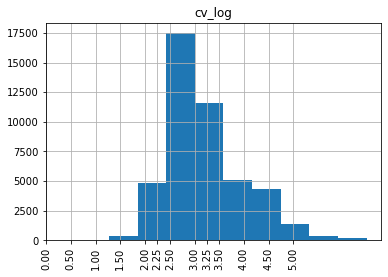

In [64]:
%matplotlib inline
# train['cv_log'] = np.log(train['count_visit']*100)
plt.figure(figsize=(10,10));
train[train['count_visit']<7].hist('cv_log', bins=10);
plt.xticks([0, 0.5, 1, 1.5, 2,2.25, 2.5, 3,3.25, 3.5, 4, 4.5, 5], rotation=90);